In [29]:
import math

# Importamos Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Importamos Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler


In [30]:
#Uso de computadora cuántica real, en los ejemplos suministrados se usa un 'ibm_sherbrooke' que tiene motor Eagle
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

/tmp/ipykernel_2275/3181594789.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


'ibm_sherbrooke'

In [31]:
def oraculo_grover(objetivos):
    """Construye una clase que instancie oráculos de Grover. Recibe los estados objetivo (estados que se busca encontrar) y retorna un Circuito 
    Cuántico representando la construcción del objetivo del oráculo
    """
    if not isinstance(objetivos, list):
        objetivos = [objetivos]
    # Identifica cantidad de qubits sobre los cuales hacer la búsqueda
    num_qubits = len(objetivos[0])

    qc = QuantumCircuit(num_qubits)
    # Ciclo a realizar por cada qubit
    for i in objetivos:
        # Escribe la entrada al revés para seguir convención de escritura de qubits
        i_rev = i[::-1]
        # Encuentra la ubicación de los "0" de la entrada
        zero_inds = [ind for ind in range(num_qubits) if i_rev.startswith("0", ind)]
        # Añade una compuerta Z multicontrol con compuertas X antes y después de los qubits cuyo objetivo es "0"
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

/tmp/ipykernel_2275/124099501.py:19: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


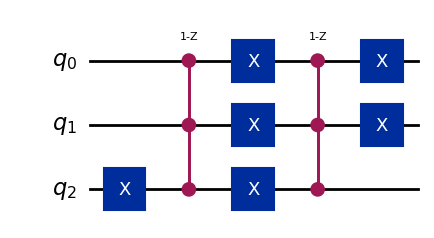

In [32]:
#Se definen las búsquedas a probar en el ejemplo
objetivos = ["011", "100"]
#Se crea el oráculo y se retorna el diseño del circuito
oraculo = oraculo_grover(objetivos)
oraculo.draw(output="mpl", style="iqp")

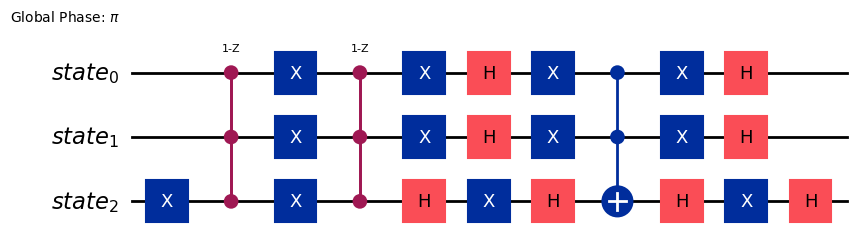

In [33]:
#
grover_op = GroverOperator(oraculo)
grover_op.decompose().draw(output="mpl", style="iqp")

In [34]:
#Se calcula la cantidad de veces t más óptima para el algoritmo. Una regla heurística es dividir el radio de los estados marcados por
#la cantidad de estados posibles total
iteraciones_t = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

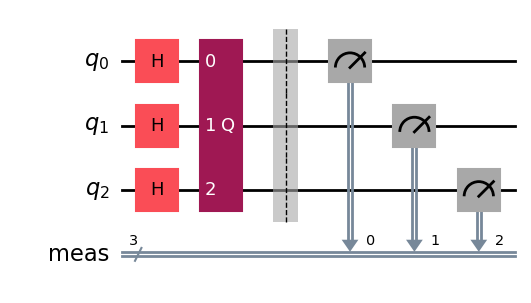

In [35]:
qc = QuantumCircuit(grover_op.num_qubits)
# Crea una superposición (compuerta Haddard) de todos los estados base
qc.h(range(grover_op.num_qubits))
# Aplica el algoritmo t veces (calculado en iteraciones_t)
qc.compose(grover_op.power(iteraciones_t), inplace=True)
# Medir todos los qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

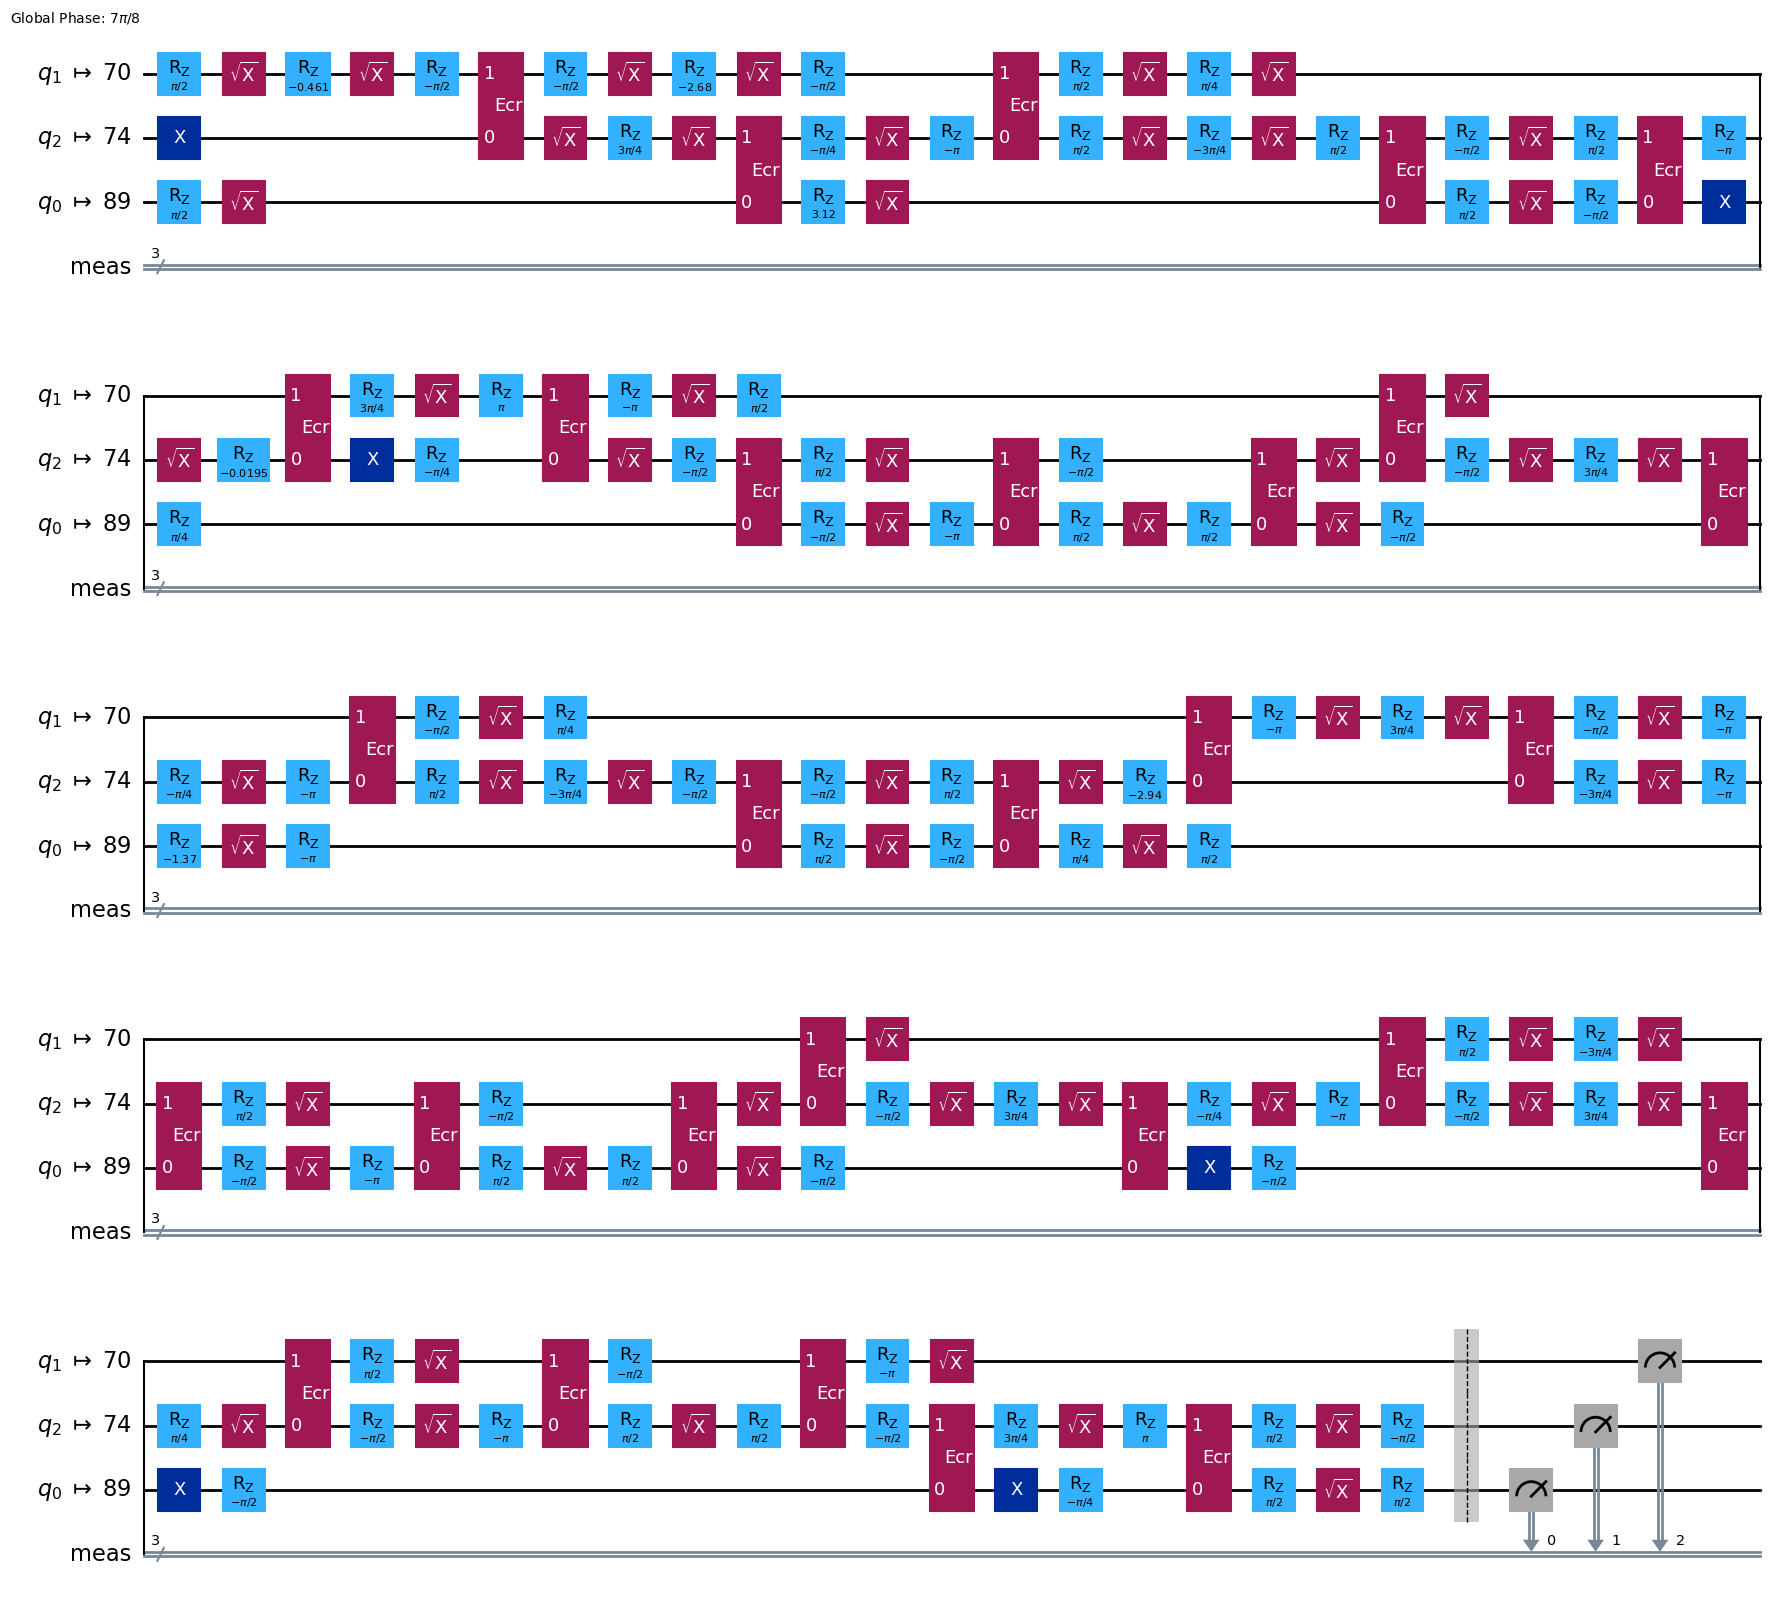

In [36]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#Proceso predefinido de optimización de la compilación para un computador cuántico
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
#Representación visual del circuito optimizado equivalente
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [40]:
# Repite cada ciclo del algoritmo n-veces
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

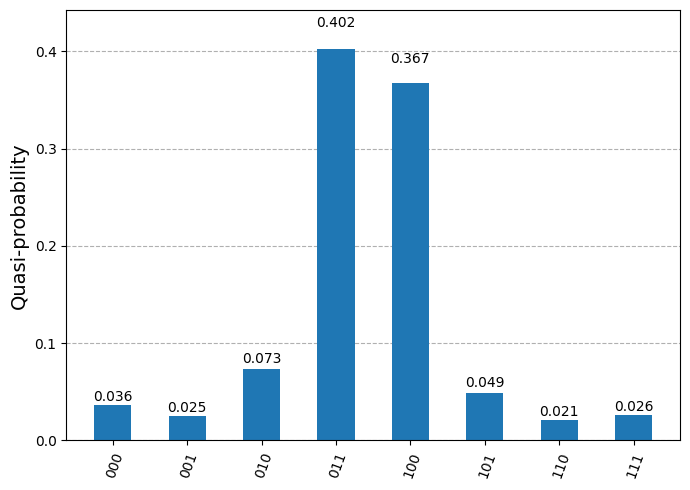

In [41]:
#Usa matplotlib para visualizar las probabilidades obtenidas
plot_distribution(dist)